# CompSci 184A/284A: FA22 Final Project

Team Members:

>  Emi Cervantes, 63486762, emic@uci.edu

>  Samir Malhotra, 58447339, smalhot2@uci.edu

>  Vatsal Ananthula, 9498724963, vananthu@uci.edu

## Loading Dataset

In [ ]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving wound_label.npy to wound_label (1).npy
Saving wound_features.npy to wound_features (1).npy


torch.Size([100, 50, 50, 3]) torch.Size([100])


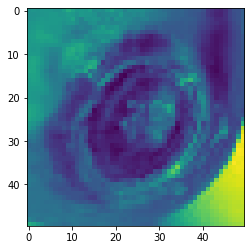

In [ ]:
X = np.load('wound_features.npy', encoding = 'bytes')
Y = np.load('wound_label.npy', encoding = 'bytes')
XTr, XTe, YTr, YTe = train_test_split(X,Y,test_size = 0.25)

batch_size = 100

torch_XTr = torch.tensor(XTr)
torch_YTr = torch.tensor(YTr)
torch_XTe = torch.tensor(XTe)
torch_YTe = torch.tensor(YTe)

train = torch.utils.data.TensorDataset(torch_XTr, torch_YTr)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)

test = torch.utils.data.TensorDataset(torch_XTe, torch_YTe)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

X, Y = next(iter(train_loader))
print(X.shape, Y.shape)

plt.imshow(XTr[100,:,:,0])

In [ ]:
# Check GPU availability
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## MLP



In [ ]:
# Hyperparameter
num_epochs_mlp = 50
num_classes = 6
batch_size = 100
learning_rate_mlp = 1e-5
input_size = 7500
hidden_size = 100

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, input_size = 7500, hidden_size = 8000, num_classes = 6):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU())
    self.fc2 = nn.Sequential(
        nn.Linear(hidden_size, 8000),
        nn.ReLU())
    self.fc3 = nn.Sequential(
        nn.Linear(8000, 8000),
        nn.ReLU())
    self.fc = nn.Linear(8000, num_classes)

  def forward(self, x):
    x = torch.swapaxes(x, 1,3)
    x = x.reshape(-1,3*50*50)
    out = self.fc1(x)
    out = self.fc2(out)
    out = self.fc(out)
    return out

mlp = NeuralNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr = learning_rate_mlp)
print(mlp)
#test run to check loss
output = mlp(X.float())
loss = criterion(output,Y)
print(loss)

NeuralNet(
  (fc1): Sequential(
    (0): Linear(in_features=7500, out_features=100, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=100, out_features=8000, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=8000, out_features=8000, bias=True)
    (1): ReLU()
  )
  (fc): Linear(in_features=8000, out_features=6, bias=True)
)
tensor(8.2495, grad_fn=<NllLossBackward0>)


In [ ]:
# Train the model
total_steptr = len(train_loader)
total_stepte = len(test_loader)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
train_lossnew = np.zeros(shape=(num_epochs_mlp*len(train_loader)))
test_lossnew = np.zeros(shape=(num_epochs_mlp*len(test_loader)))
train_accnew = np.zeros(shape=(num_epochs_mlp*len(train_loader)),dtype=np.float64)
test_accnew = np.zeros(shape=(num_epochs_mlp*len(test_loader)),dtype = np.float64)
z = 0
b = 0

#Train Model
for epoch in range(num_epochs_mlp):    
    for i, (X, Y) in enumerate(train_loader):
        mlp.train()
        X = X.to(device)
        Y = Y.to(device)

        # Forward pass       
        outputs = mlp(X.float())   

        # Calculate Loss     
        loss = criterion(outputs, Y)

        # Backward and optimize   
        optimizer.zero_grad()     
        loss.backward()
        optimizer.step()     
        _, predictedtr = torch.max(outputs.data, 1)
        train_loss.append(loss.item())
        train_acc.append((predictedtr == Y).sum().item() / predictedtr.size(0))  

        #store loss and iteration
        
        if (i+1) % 6 == 0:                       
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train Accuracy: {}' 
                  .format(epoch+1, num_epochs_mlp, (i+1), total_steptr, loss.item(),(100*np.mean(train_acc))))   
            train_lossnew[z+5] = loss.item()                          
            train_accnew[z+5] = 100*np.mean(train_acc)
            z += 5
#Test Model         
    with torch.no_grad():              
        for j, (X, Y) in enumerate(test_loader):
            mlp.eval()
            X = X.to(device)
            Y = Y.to(device)
            outputs = mlp(X.float())
            loss2 = criterion(outputs, Y)
            test_loss.append(loss2.item())
            _, predictedte = torch.max(outputs.data, 1)
            test_acc.append((predictedte == Y).sum().item() / predictedte.size(0))

            if (j+1) % 2 == 0:    
                print('Epoch [{}/{}],  Step [{}/{}], Loss: {:.4f}, Test Accuracy: {}' 
                    .format(epoch+1, num_epochs_mlp, (j+1), total_stepte, loss2.item(),(100*np.mean(test_acc))))    
                test_lossnew[b+1] = loss2.item()     
                test_accnew[b+1] = 100*np.mean(test_acc)
                b += 1

Epoch [1/50], Step [6/6], Loss: 6.2276, Train Accuracy: 17.496855345911946
Epoch [1/50],  Step [2/2], Loss: 4.8516, Test Accuracy: 15.823529411764708
Epoch [2/50], Step [6/6], Loss: 4.5553, Train Accuracy: 19.440251572327046
Epoch [2/50],  Step [2/2], Loss: 3.8307, Test Accuracy: 18.676470588235293
Epoch [3/50], Step [6/6], Loss: 3.3210, Train Accuracy: 20.848008385744237
Epoch [3/50],  Step [2/2], Loss: 3.0420, Test Accuracy: 19.76470588235294
Epoch [4/50], Step [6/6], Loss: 2.4997, Train Accuracy: 22.209119496855344
Epoch [4/50],  Step [2/2], Loss: 2.5792, Test Accuracy: 23.02941176470588
Epoch [5/50], Step [6/6], Loss: 2.0256, Train Accuracy: 25.110062893081757
Epoch [5/50],  Step [2/2], Loss: 2.5033, Test Accuracy: 24.770588235294117
Epoch [6/50], Step [6/6], Loss: 2.0451, Train Accuracy: 27.053459119496846
Epoch [6/50],  Step [2/2], Loss: 2.2848, Test Accuracy: 26.151960784313726
Epoch [7/50], Step [6/6], Loss: 2.1190, Train Accuracy: 28.336028751123095
Epoch [7/50],  Step [2/2], 

In [ ]:
train_lossnew = train_lossnew[train_lossnew != 0]
train_accnew = train_accnew[train_accnew != 0]  

test_lossnew = test_lossnew[test_lossnew != 0]
test_accnew = test_accnew[test_accnew != 0]  

#Classification Report
y_pred_list = []
y_target_list = []
with torch.no_grad():
    mlp.eval()
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        outputs = mlp(X.float())        
        _, y_pred_tags = torch.max(outputs, 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_target_list.append(Y.detach().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = sum(y_pred_list, [])

y_target_list = [a.squeeze().tolist() for a in y_target_list]
y_target_list = sum(y_target_list, [])


print("-------Precision, Recall, F1-Score, and Suport of MLP---------")
print()
print(classification_report(y_target_list, y_pred_list))

-------Precision, Recall, F1-Score, and Suport of MLP---------

              precision    recall  f1-score   support

           0       0.76      0.70      0.73        23
           1       0.43      0.58      0.50        43
           2       0.67      0.72      0.69        25
           3       0.10      0.04      0.06        25
           4       0.38      0.26      0.31        35
           5       0.49      0.65      0.56        34

    accuracy                           0.49       185
   macro avg       0.47      0.49      0.47       185
weighted avg       0.46      0.49      0.47       185



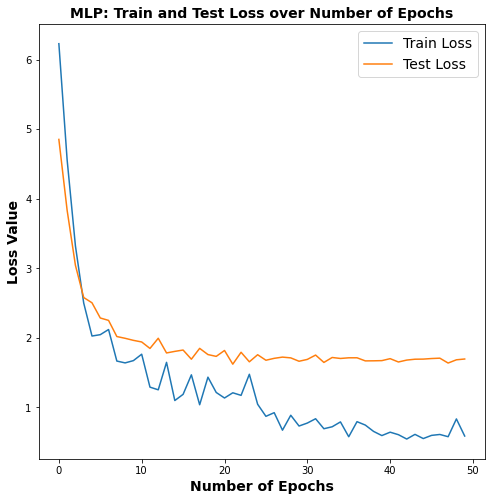

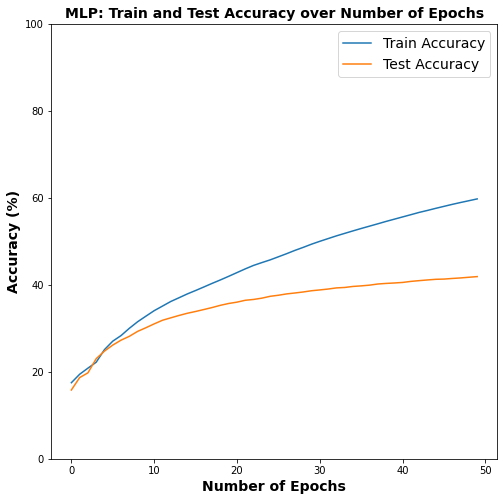

In [ ]:
#Visualization of Loss and Accuracy
fig1 = plt.figure(figsize=(8,8))
X1 = fig1.add_subplot(1,1,1)
X1.plot(train_lossnew, label = 'Train Loss')
X1.plot(test_lossnew, label = 'Test Loss')
X1.set_title('MLP: Train and Test Loss over Number of Epochs', fontsize = 14, fontweight = 'bold')
X1.set_xlabel('Number of Epochs',fontsize = 14, fontweight = 'bold')
X1.set_ylabel('Loss Value',fontsize = 14, fontweight = 'bold')
X1.legend(fontsize = 14)



fig2 = plt.figure(figsize=(8,8))
X2 = fig2.add_subplot(1,1,1)
X2.plot(train_accnew, label = 'Train Accuracy')
X2.plot(test_accnew, label = 'Test Accuracy')
X2.set_ylim([0, 100])
X2.set_title('MLP: Train and Test Accuracy over Number of Epochs', fontsize = 14, fontweight = 'bold')
X2.set_xlabel('Number of Epochs',fontsize = 14, fontweight = 'bold')
X2.set_ylabel('Accuracy (%)',fontsize = 14, fontweight = 'bold')
X2.legend(fontsize = 14)

## CNN

In [ ]:
# Hyperparameters
num_epochs_cnn = 50
num_classes_cnn = 6
batch_size_cnn = 100
learning_rate_cnn = 1e-4

### CNN layers
- Layer 1: Perform Convolution to a 2D data, then Batch Normalization, then a Tanh activation funtion, and lastly applying a 2D Max-Pooling layer
- Layer 2: Perform Convolution to the 2D data that outputs from first layer, then Batch Normalization, then a ReLU activation function, and lastly applying a 2D Max-Pooling layer
- Fully Connected Linear Layer
- Implement a forward method

In [ ]:
# CNN
print(X.shape) #Check original shape of X
class ConvNet(nn.Module):
  def __init__(self, num_classes_cnn = 6):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 4, stride = 1, padding = 2),
        nn.BatchNorm2d(64),        
        nn.Tanh(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size = 4, stride = 1, padding = 2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)  
    )
    self.fc = nn.Linear(21632, num_classes_cnn)

  def forward(self, X):
    X = torch.swapaxes(X, 1,3)
    out = self.layer1(X.float())    
    out = self.layer2(out)   
    out = out.reshape(out.size(0), -1)    
    out = self.fc(out)
    return out

torch.Size([85, 50, 50, 3])


In [ ]:
cnn = ConvNet(num_classes_cnn).to(device)
output = cnn(X)
print(output.shape)

torch.Size([85, 6])


#### Implement CrossEntropyLoss function to measure the performance of the CNN classification model.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = learning_rate_cnn)
print(cnn)
#test run to check loss
loss = criterion(output,Y)
print(loss)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=21632, out_features=6, bias=True)
)
tensor(1.8835, grad_fn=<NllLossBackward0>)


#### Train then Test Model.
- Shows Train and Test loss and accuracy for each Epoch

In [ ]:
# Train the model
total_steptr = len(train_loader)
total_stepte = len(test_loader)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
train_lossnew = np.zeros(shape=(num_epochs_cnn*len(train_loader)))
test_lossnew = np.zeros(shape=(num_epochs_cnn*len(test_loader)))
train_accnew = np.zeros(shape=(num_epochs_cnn*len(train_loader)),dtype=np.float64)
test_accnew = np.zeros(shape=(num_epochs_cnn*len(test_loader)),dtype = np.float64)
z = 0
b = 0

#Train Model
for epoch in range(num_epochs_cnn):    
    for i, (X, Y) in enumerate(train_loader):
        cnn.train()
        X = X.to(device)
        Y = Y.to(device)

        # Forward pass       
        outputs = cnn(X)   

        # Calculate Loss     
        loss = criterion(outputs, Y)

        # Backward and optimize   
        optimizer.zero_grad()     
        loss.backward()
        optimizer.step()     
        _, predictedtr = torch.max(outputs.data, 1)
        train_loss.append(loss.item())
        train_acc.append((predictedtr == Y).sum().item() / predictedtr.size(0))  

        #store loss and iteration
        
        if (i+1) % 6 == 0:                       
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Train Accuracy: {}' 
                  .format(epoch+1, num_epochs_cnn, (i+1), total_steptr, loss.item(),(100*np.mean(train_acc))))   
            train_lossnew[z+5] = loss.item()                          
            train_accnew[z+5] = 100*np.mean(train_acc)
            z += 5
#Test Model         
    with torch.no_grad():              
        for j, (X, Y) in enumerate(test_loader):
            cnn.eval()
            X = X.to(device)
            Y = Y.to(device)
            outputs = cnn(X)
            loss2 = criterion(outputs, Y)
            test_loss.append(loss2.item())
            _, predictedte = torch.max(outputs.data, 1)
            test_acc.append((predictedte == Y).sum().item() / predictedte.size(0))

            if (j+1) % 2 == 0:    
                print('Epoch [{}/{}],  Step [{}/{}], Loss: {:.4f}, Test Accuracy: {}' 
                    .format(epoch+1, num_epochs_cnn, (j+1), total_stepte, loss2.item(),(100*np.mean(test_acc))))    
                test_lossnew[b+1] = loss2.item()     
                test_accnew[b+1] = 100*np.mean(test_acc)
                b += 1

Epoch [1/50], Step [6/6], Loss: 1.6068, Train Accuracy: 35.58490566037736
Epoch [1/50],  Step [2/2], Loss: 1.5796, Test Accuracy: 38.911764705882355
Epoch [2/50], Step [6/6], Loss: 0.9449, Train Accuracy: 45.314465408805034
Epoch [2/50],  Step [2/2], Loss: 1.2956, Test Accuracy: 45.26470588235295
Epoch [3/50], Step [6/6], Loss: 0.8186, Train Accuracy: 51.79769392033543
Epoch [3/50],  Step [2/2], Loss: 1.1935, Test Accuracy: 47.86274509803922
Epoch [4/50], Step [6/6], Loss: 0.8194, Train Accuracy: 55.95125786163522
Epoch [4/50],  Step [2/2], Loss: 1.1272, Test Accuracy: 50.74999999999999
Epoch [5/50], Step [6/6], Loss: 0.7227, Train Accuracy: 58.272955974842766
Epoch [5/50],  Step [2/2], Loss: 1.1167, Test Accuracy: 51.558823529411754
Epoch [6/50], Step [6/6], Loss: 0.7185, Train Accuracy: 60.68501048218029
Epoch [6/50],  Step [2/2], Loss: 1.0532, Test Accuracy: 52.75490196078431
Epoch [7/50], Step [6/6], Loss: 0.8080, Train Accuracy: 62.18059299191374
Epoch [7/50],  Step [2/2], Loss: 1

In [ ]:
train_lossnew = train_lossnew[train_lossnew != 0]
train_accnew = train_accnew[train_accnew != 0]  

test_lossnew = test_lossnew[test_lossnew != 0]
test_accnew = test_accnew[test_accnew != 0]  


In [ ]:
#Classification Report
y_pred_list = []
y_target_list = []
with torch.no_grad():
    cnn.eval()
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        outputs = cnn(X)        
        _, y_pred_tags = torch.max(outputs, 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_target_list.append(Y.detach().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = sum(y_pred_list, [])

y_target_list = [a.squeeze().tolist() for a in y_target_list]
y_target_list = sum(y_target_list, [])


print("-------Precision, Recall, F1-Score, and Suport of MLP---------")
print()
print(classification_report(y_target_list, y_pred_list))

-------Precision, Recall, F1-Score, and Suport of MLP---------

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.64      0.53      0.58        43
           2       0.92      0.88      0.90        25
           3       0.55      0.24      0.33        25
           4       0.48      0.46      0.47        35
           5       0.48      0.82      0.61        34

    accuracy                           0.62       185
   macro avg       0.66      0.63      0.63       185
weighted avg       0.63      0.62      0.61       185



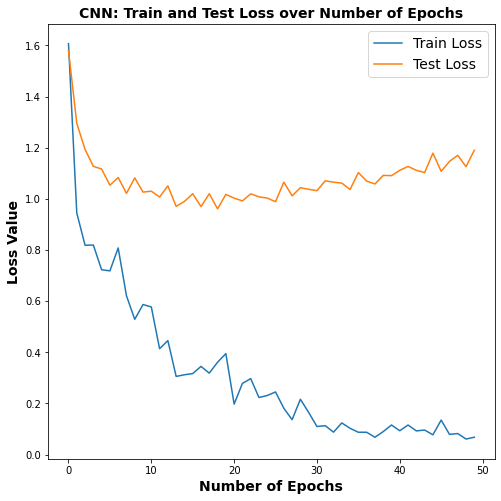

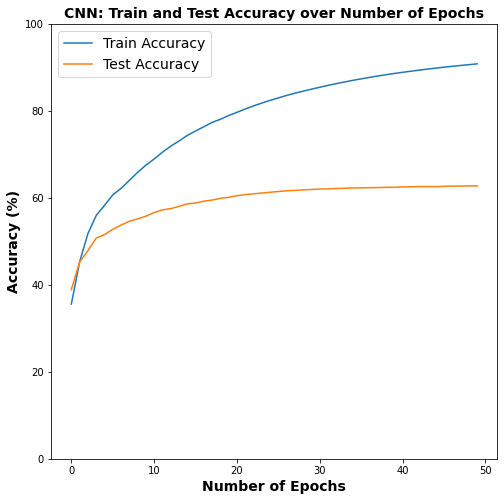

In [ ]:
#Visualization of Loss and Accuracy
fig1 = plt.figure(figsize=(8,8))
X1 = fig1.add_subplot(1,1,1)
X1.plot(train_lossnew, label = 'Train Loss')
X1.plot(test_lossnew, label = 'Test Loss')
X1.set_title('CNN: Train and Test Loss over Number of Epochs', fontsize = 14, fontweight = 'bold')
X1.set_xlabel('Number of Epochs',fontsize = 14, fontweight = 'bold')
X1.set_ylabel('Loss Value',fontsize = 14, fontweight = 'bold')
X1.legend(fontsize = 14)

fig2 = plt.figure(figsize=(8,8))
X2 = fig2.add_subplot(1,1,1)
X2.plot(train_accnew, label = 'Train Accuracy')
X2.plot(test_accnew, label = 'Test Accuracy')
X2.set_ylim((0,100))
X2.set_title('CNN: Train and Test Accuracy over Number of Epochs', fontsize = 14, fontweight = 'bold')
X2.set_xlabel('Number of Epochs',fontsize = 14, fontweight = 'bold')
X2.set_ylabel('Accuracy (%)',fontsize = 14, fontweight = 'bold')
X2.legend(fontsize = 14)

## VGG

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')
print(model.summary())

553467096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            